In [1]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms
import torchvision.datasets as datasets



print('done')

done


In [2]:
# mnist data reader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1071448d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1071446d8>)

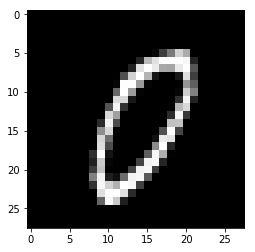

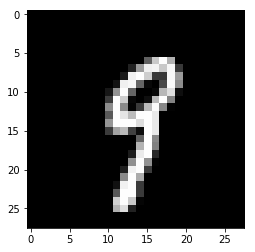

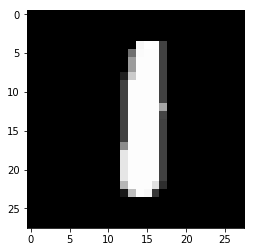

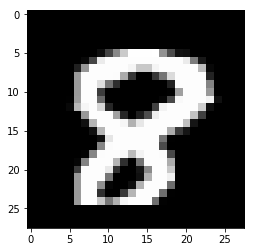

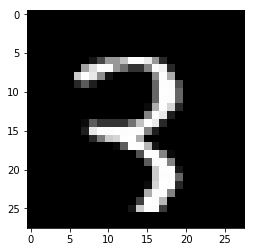

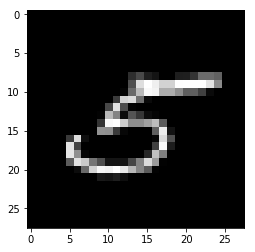

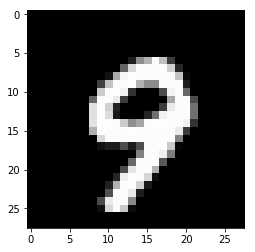

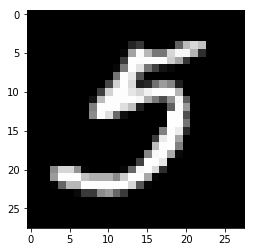

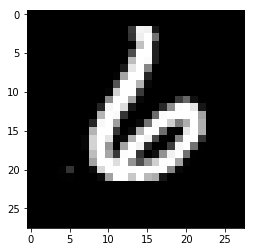

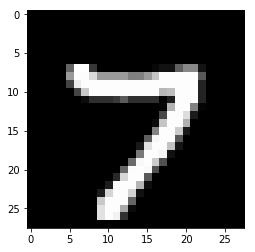

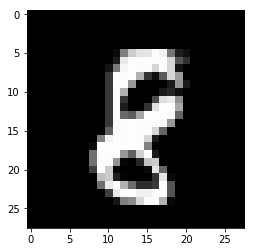

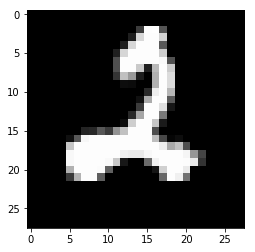

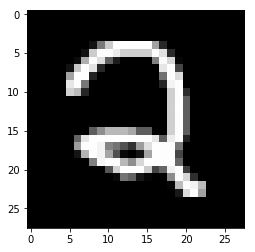

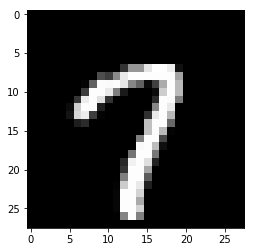

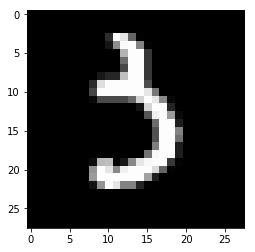

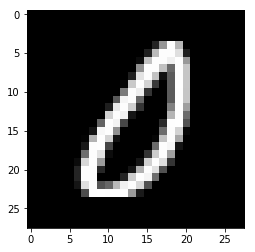

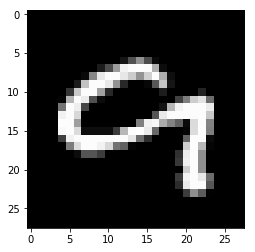

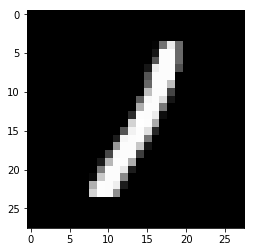

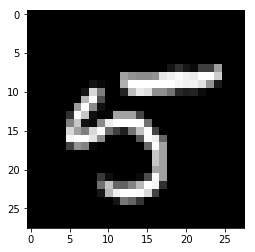

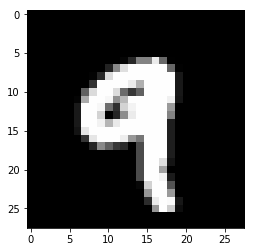

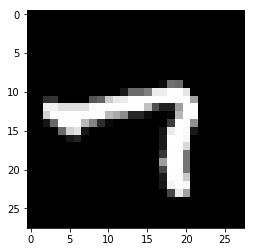

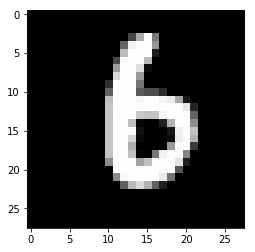

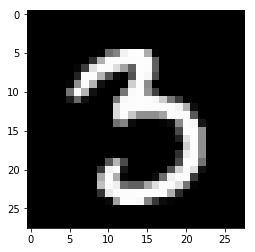

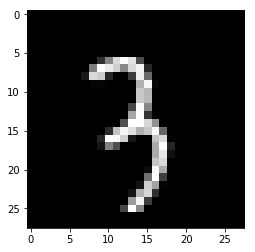

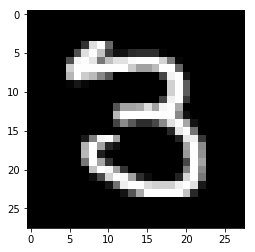

In [3]:
# mnist data reader

def gray_to_rgb(x):
    x = np.array(x[0,:,:]) 
    return torch.tensor(np.stack([x,x,x], axis = -1).reshape((3,28,28)))

normalize = transforms.Normalize((0.1307,), (0.1307,))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 25

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

for i, (inputs, outputs) in enumerate(train_loader):
    for image in inputs.numpy():
        image = image.reshape((28,28))
        plt.imshow(image, cmap = 'gray')
        plt.show()
    break

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64 * 9, 120)
        self.fc2 = nn.Linear(120,120)
        self.encoding = nn.Linear(120,25)
        self.fc3 = nn.Linear(25,10)
        
        
    def forward(self, x):
        x = x.reshape((x.shape[0],1,28,28))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.encoding(x))
        
        return self.fc3(encoded), encoded
        

    
classifier = Classifier()
classifier(torch.randn((1,1,28,28)))
classifier

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (encoding): Linear(in_features=120, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum = 0.9)
print('donem')

donem


In [7]:
def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions, encoded = model(inputs)
            loss = metric(predictions, outputs)  
            #loss += 0.0001 * torch.sum(torch.abs(encoded))
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(i, j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 3, log_every = 100)

0 0 2.3021726608276367 0.08
100 0 1.9991056476489153 0.30376237623762375
200 0 1.3727132373336535 0.5221890547263681
300 0 1.0483675160603072 0.6427906976744187
400 0 0.8636379757166801 0.708428927680798
500 0 0.7300696073624189 0.7550499001996008
600 0 0.6410062893746288 0.7871547420965058
700 0 0.5715562998942935 0.8102710413694721
800 0 0.517751673902135 0.8281148564294631
900 0 0.4787707442805878 0.8419089900110988
1000 0 0.44292780743029386 0.854025974025974
1100 0 0.4153755966075514 0.8634695731153497
1200 0 0.38836358453030406 0.8726727726894254
1300 0 0.3652151877481632 0.8806149116064566
1400 0 0.34752243821355294 0.8869093504639544
1500 0 0.3304521189043162 0.8925782811459028
1600 0 0.3162593846186806 0.8974391005621487
1700 0 0.3024193808910131 0.901845972957084
1800 0 0.2900522626482797 0.9059855635757912
1900 0 0.27991371058097364 0.9095423461336138
2000 0 0.2700199508955279 0.9129435282358821
2100 0 0.2611633639493762 0.9159257496430271
2200 0 0.25307522651426617 0.918600

In [8]:
# Monitor accuracy in test and train 
# Quality monitoring visualizaing incorrect and correct in test and train
# Transfer learning
# Image augmentations
# Visualzaing what conv layers learn
# Visualize what activations learn

def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions, encoded = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
    return correct / total
        
        
evaluate(classifier, test_loader)

0.9858

In [ ]:
# find which neurons get activated for a given digit
from collections import defaultdict


def get_activating_neurons(digit, test_loader):
    d = defaultdict(list)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()].append(rep.detach().numpy())
    d[digit] = np.array(d[digit])
    d[digit] = np.mean(d[digit], axis = 0)
    plt.figure(figsize=(10,5))
    plt.bar(range(0,25), d[digit])
    plt.xticks(range(0,25))
    plt.show()
        

for i in range(0,10):
    print('activating neurons for digit ', i)
    get_activating_neurons(i, test_loader)

In [ ]:
### find digits which activate a neuron


def get_activating_digit(dim_number, test_loader):
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()] += rep.detach().numpy()[dim_number]
    d = sorted(d.items())        
    x = [ e[0] for e in d ]
    y = [ e[1] for e in d ]
    plt.bar(x, y)
    plt.xticks(range(0,10), range(0,10))
    plt.show()

for i in range(25):
    print("digit activation graph of neuron " + str(i))
    get_activating_digit(i, test_loader)
        
        
    


ACTIVATION IMAGES AND HEATMAPS


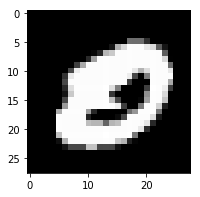

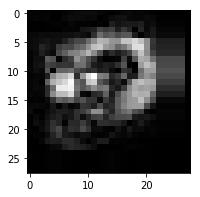

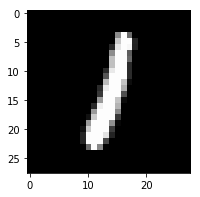

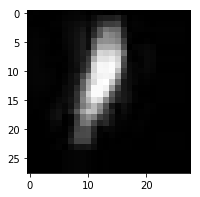

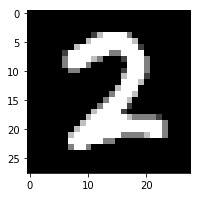

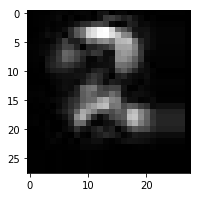

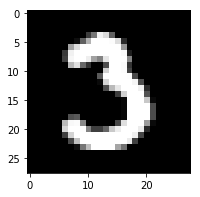

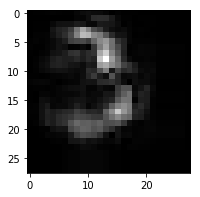

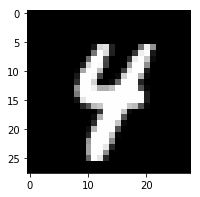

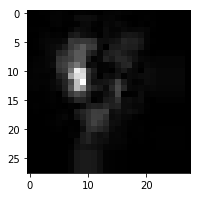

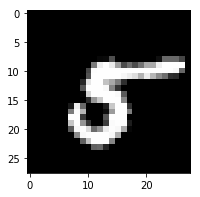

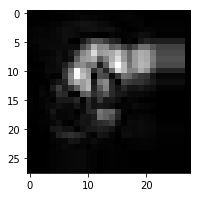

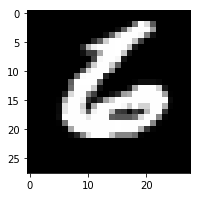

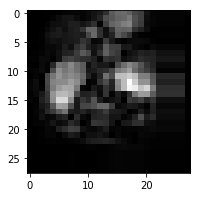

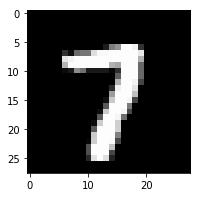

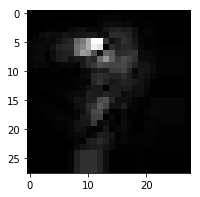

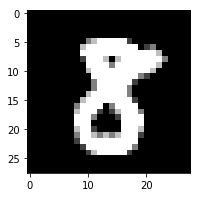

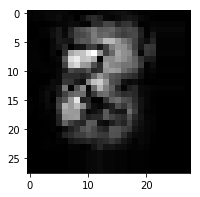

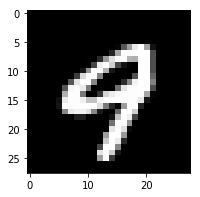

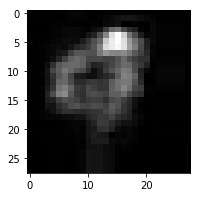

In [9]:
# Find what part of image contributes to probability score by occluding image
from collections import defaultdict

def get_activation_heatmap(digit, test_loader):
    digit_images = None
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        for image, output in zip(inputs, outputs):
            if output.item() == digit:
                digit_image = image
    
   
    heat_map = np.zeros((28,28))
    

    digit_image = digit_image.reshape((28,28,1))
    actual_predictions, actual_encoded = classifier(digit_image.reshape((1,28,28,1)))
    

    for i in range(25):
        for j in range(23):
            occluded_image = digit_image.numpy().copy()
            occluded_image[i:i+5,j:j+5] = 0
            occluded_predictions, occluded_encoded = classifier(torch.tensor(occluded_image.reshape((1,28,28,1))))
            difference = 255 * abs(actual_predictions[0][1].item() - occluded_predictions[0][1].item())
            heat_map[i:i+5,j:j+5] = difference
        
    
    
    plt.figure(figsize=(3,3))
    plt.imshow(digit_image.reshape((28,28)), cmap = 'gray')
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(heat_map, cmap = 'gray')
    plt.show()
        
       

            
print('ACTIVATION IMAGES AND HEATMAPS')      

for digit in range(10):
    get_activation_heatmap(digit, test_loader) 

In [8]:
# Find what part of image contributes to probability score by occluding image


def get_activating_patch(dim_number, test_loader):
    max_activation = 0
    activating_patch = None
    k = 0
    for inputs, outputs in test_loader:
        k += 1
        for image, output in zip(inputs, outputs):
            un_image =  image.numpy()[0].copy() * 0.137 + 0.137
            n_image = image.numpy()[0].copy()

            for i in range(25):
                for j in range(25):
                    un_patch = np.zeros((28,28))
                    patch = np.zeros((28,28))
                    un_patch[i:i+3][j:j+3] = un_image.copy()[i:i+3][j:j+3]
                    patch[i:i+3][j:j+3] = n_image.copy()[i:i+3][j:j+3]
                    predictions, encoded = classifier(torch.tensor(patch, dtype = torch.float32).reshape((1,1,28,28)))
                    if abs(encoded[0][dim_number].item()) > max_activation:
                        max_activation = encoded[0][dim_number].item()
                        activating_patch = un_patch.copy()
        if k>=10:
            break
              
    if activating_patch:
        plt.imshow(activating_patch, cmap = 'gray')         
        plt.show() 
            

                        
                    
                    
    
for i in range(25):
    print('ACTIVATION PATCH FOR NEURON ', i)
    get_activating_patch(i, test_loader)
    

ACTIVATION PATCH FOR NEURON  0


KeyboardInterrupt: 

### localization is a natural result of classification

### Generate image given class

In [16]:
def freeze_model():
    for param in classifier.parameters():
        param.requires_grad = False
    print('done')
def display(image):
    plt.figure(figsize=(2,2))
    plt.imshow(image.reshape((28,28)), cmap = 'gray')
    plt.show()
#freeze_model()

In [ ]:

def generate_most_confident_image(digit):
    x = torch.randn((1,1,28,28), requires_grad = True)
    lr = 1
    for i in range(50000):
        predictions, encoded = classifier(x)
        loss = -predictions[0][digit]
        loss.backward()
        with torch.no_grad():
            x -= lr * x.grad
            x.grad.zero_()
            if i % 1000 == 0:
                print(i, loss.item(), predictions[0][digit])

    x = x.detach().numpy()
    x = x.reshape((28,28))
    plt.figure(figsize=(2,2))
    plt.imshow(x, cmap = 'gray')
    plt.show()

    return torch.softmax(classifier(torch.tensor(x).reshape(1,1,28,28))[0][0], dim = 0)

for i in range(10):

    generate_most_confident_image(i)

### Untargetted attack using FSGM

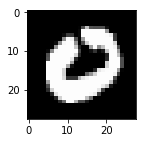

tensor(0)


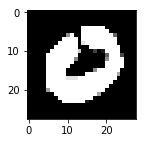

tensor(8)










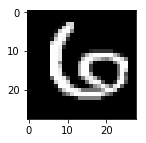

tensor(6)


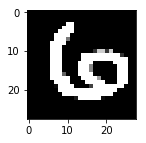

tensor(8)










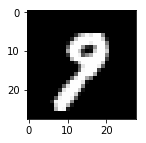

tensor(9)


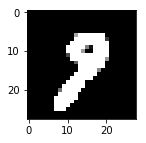

tensor(8)










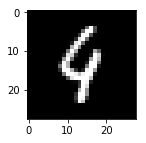

tensor(4)


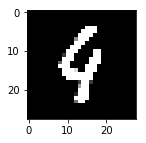

tensor(8)










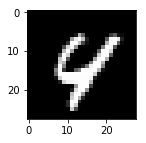

tensor(4)


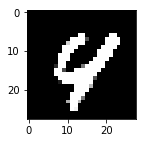

tensor(9)










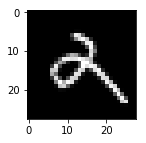

tensor(2)


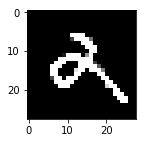

tensor(3)










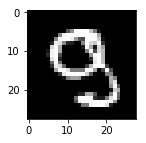

tensor(9)


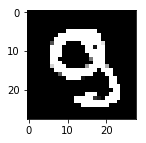

tensor(8)










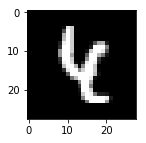

tensor(4)


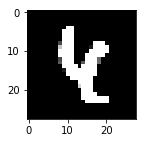

tensor(1)










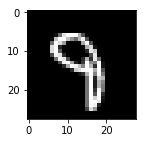

tensor(9)


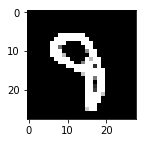

tensor(8)










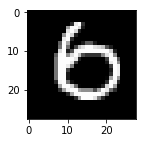

tensor(6)


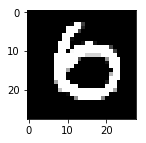

tensor(0)










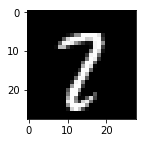

tensor(2)


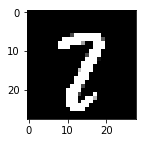

tensor(7)




num attacked 11


In [139]:
def predict_probs(image, classfier):
    return classifier(image.reshape((1,1,28,28)))[0]
    
def predict(image, classifier):
    return predict_probs(image, classifier)[0].argmax()


def do_untargetted_attack(image, classifier):
    adv_image = image + 0.3 * torch.sign(image.grad.data)
    return torch.clamp(adv_image, 0, 1)
    
mistakes = 0
metric = nn.CrossEntropyLoss()
for inputs, outputs in test_loader:
    for image, target in zip(inputs, outputs):
        image.requires_grad = True
        classifier.zero_grad()
        predictions = predict_probs(image, classifier)
        prediction = predict(image, classifier)
        loss = metric(predictions, target.reshape(1,))
        loss.backward()
        
        adv_image = do_untargetted_attack(image, classifier)
        new_prediction = predict(adv_image, classifier)
        
        is_prediction_correct = (prediction == target).item()
        is_attack_success = (prediction != new_prediction).item()
        
        if is_prediction_correct and is_attack_success:
            print('\n\n\n')
            mistakes += 1
            display(image.data)
            print(prediction)
            display(adv_image.data)
            print(new_prediction)
            print('\n\n\n')
    if mistakes > 10:
        break

print('num attacked', mistakes)

### LTA ( Lame targetted Attack )

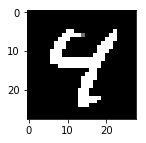

tensor(4) tensor(4) tensor(9)


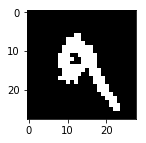

tensor(9) tensor(9) tensor(8)


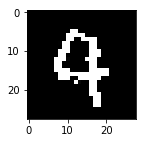

tensor(4) tensor(4) tensor(9)
done


In [138]:
metric = nn.CrossEntropyLoss()
adv_target = torch.tensor(1, dtype = torch.long)
adv_target = adv_target.reshape((1,))
lr = 0.1
adv_target = torch.tensor(0, dtype = torch.long)
adv_target = adv_target.reshape((1,))
for inputs, outputs in test_loader:
    for image, target in zip(inputs, outputs):
        original_image = image
        image.requires_grad = True 
        prediction = predict(image, classifier)
        for i in range(20):
            adv_predictions = predict_probs(image, classifier)
            loss = metric(adv_predictions, adv_target)
            loss.backward()
            with torch.no_grad():
                image -= lr * image.grad
                image.data = (image.data - image.data.mean()) / (image.data.std() + 0.00001)
                image.data = torch.clamp(image.data, 0, 1)
        adv_prediction = predict(image, classifier)
        if (target == prediction).item() and (prediction != adv_prediction).item():
            display(image.data)
            print(target, prediction, adv_prediction)
        
        
    break
print('done')

In [107]:
'done'

'done'